## 6. Decision Trees and Ensemble Learning
This week, we'll talk about decision trees and tree-based ensemble algorithms
Risk of defaulting

### 6.1 Credit risk scoring project
Dataset: https://github.com/gastonstat/CreditScoring


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### 6.2 Data cleaning and preparation
- Downloading the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
!wget $data

--2024-11-03 21:01:50--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.003s  

2024-11-03 21:01:50 (55.8 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



In [4]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [66]:
df = pd.read_csv(data)

In [67]:
df.columns = df.columns.str.lower()

In [68]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [69]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

"""
Maps the status values in the 'status' column of the DataFrame to their corresponding string representations.

The `status_values` dictionary is used to map the integer status codes to their respective string values:
    - 1: 'ok'
    - 2: 'default'
    - 0: 'unk'

The `map` function is applied to the 'status' column of the DataFrame `df` to replace the integer codes with the corresponding string values.

Args:
    df (pd.DataFrame): The DataFrame containing the 'status' column to be mapped.

Returns:
    pd.Series: The 'status' column with mapped string values.
"""

df.status = df.status.map(status_values)

In [70]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [71]:
df.head()

status  seniority   home  time  age  marital records        job  expenses  \
0       ok          9   rent    60   30  married      no  freelance        73   
1       ok         17   rent    60   58    widow      no      fixed        48   
2  default         10  owner    36   46  married     yes  freelance        90   
3       ok          0   rent    60   24   single      no      fixed        63   
4       ok          0   rent    36   26   single      no      fixed        46   

   income  assets  debt  amount  price  
0     129       0     0     800    846  
1     131       0     0    1000   1658  
2     200    3000     0    2000   2985  
3     182    2500     0     900   1325  
4     107       0     0     310    910

In [72]:
df.describe().round()

seniority    time     age  expenses      income      assets  \
count     4455.0  4455.0  4455.0    4455.0      4455.0      4455.0   
mean         8.0    46.0    37.0      56.0    763317.0   1060341.0   
std          8.0    15.0    11.0      20.0   8703625.0  10217569.0   
min          0.0     6.0    18.0      35.0         0.0         0.0   
25%          2.0    36.0    28.0      35.0        80.0         0.0   
50%          5.0    48.0    36.0      51.0       120.0      3500.0   
75%         12.0    60.0    45.0      72.0       166.0      6000.0   
max         48.0    72.0    68.0     180.0  99999999.0  99999999.0   

             debt  amount    price  
count      4455.0  4455.0   4455.0  
mean     404382.0  1039.0   1463.0  
std     6344253.0   475.0    628.0  
min           0.0   100.0    105.0  
25%           0.0   700.0   1118.0  
50%           0.0  1000.0   1400.0  
75%           0.0  1300.0   1692.0  
max    99999999.0  5000.0  11140.0

In [73]:
for c in ['income', 'assets', 'debt']:
    """
    Replaces the value 99999999 with NaN in the specified columns of the DataFrame.

    Iterates over the columns 'income', 'assets', and 'debt' in the DataFrame `df` 
    and replaces any occurrence of the value 99999999 with NaN.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be modified.

    Returns:
        None: The function modifies the DataFrame in place.
    """
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [74]:
df.describe().round()

seniority    time     age  expenses  income    assets     debt  amount  \
count     4455.0  4455.0  4455.0    4455.0  4421.0    4408.0   4437.0  4455.0   
mean         8.0    46.0    37.0      56.0   131.0    5403.0    343.0  1039.0   
std          8.0    15.0    11.0      20.0    86.0   11573.0   1246.0   475.0   
min          0.0     6.0    18.0      35.0     0.0       0.0      0.0   100.0   
25%          2.0    36.0    28.0      35.0    80.0       0.0      0.0   700.0   
50%          5.0    48.0    36.0      51.0   120.0    3000.0      0.0  1000.0   
75%         12.0    60.0    45.0      72.0   165.0    6000.0      0.0  1300.0   
max         48.0    72.0    68.0     180.0   959.0  300000.0  30000.0  5000.0   

         price  
count   4455.0  
mean    1463.0  
std      628.0  
min      105.0  
25%     1118.0  
50%     1400.0  
75%     1692.0  
max    11140.0

In [75]:
df = df[df.status != 'unk'].reset_index(drop=True)
"""
Filter out rows where the 'status' column is 'unk' and reset the DataFrame index.

This operation removes all rows from the DataFrame where the 'status' column has the value 'unk'.
After filtering, the index of the DataFrame is reset to start from 0, and the old index is dropped.

Returns:
    DataFrame: A new DataFrame with the filtered rows and reset index.
"""

"\nFilter out rows where the 'status' column is 'unk' and reset the DataFrame index.\n\nThis operation removes all rows from the DataFrame where the 'status' column has the value 'unk'.\nAfter filtering, the index of the DataFrame is reset to start from 0, and the old index is dropped.\n\nReturns:\n    DataFrame: A new DataFrame with the filtered rows and reset index.\n"

In [76]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [77]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [78]:
y_train = (df_train.status == 'default').astype('int').values
"""
Convert the 'status' column to binary values indicating default status.

# Comment:
# The following lines convert the 'status' column in the training, validation, 
# and test datasets to binary values where 'default' is represented as 1 
# and any other status is represented as 0.
"""
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [79]:
del df_train['status']
del df_val['status']
del df_test['status']

In [80]:
df_train

seniority     home  time  age  marital records        job  expenses  \
0            10    owner    36   36  married      no  freelance        75   
1             6  parents    48   32   single     yes      fixed        35   
2             1  parents    48   40  married      no      fixed        75   
3             1  parents    48   23   single      no    partime        35   
4             5    owner    36   46  married      no  freelance        60   
...         ...      ...   ...  ...      ...     ...        ...       ...   
2667         18  private    36   45  married      no      fixed        45   
2668          7  private    60   29  married      no      fixed        60   
2669          1  parents    24   19   single      no      fixed        35   
2670         15    owner    48   43  married      no  freelance        60   
2671         12    owner    48   27  married     yes      fixed        45   

      income   assets    debt  amount  price  
0        0.0  10000.0     0.0    1000   1400  
1       85.0      0.0     0.0    1100   1330  
2      121.0      0.0     0.0    1320   1600  
3       72.0      0.0     0.0    1078   1079  
4      100.0   4000.0     0.0    1100   1897  
...      ...      ...     ...     ...    ...  
2667   220.0  20000.0     0.0     800   1600  
2668    51.0   3500.0   500.0    1000   1290  
2669    28.0      0.0     0.0     400    600  
2670   100.0  18000.0     0.0    2500   2976  
2671   110.0   5000.0  1300.0     450   1636  

[2672 rows x 13 columns]

### 6.3 Decision trees
- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

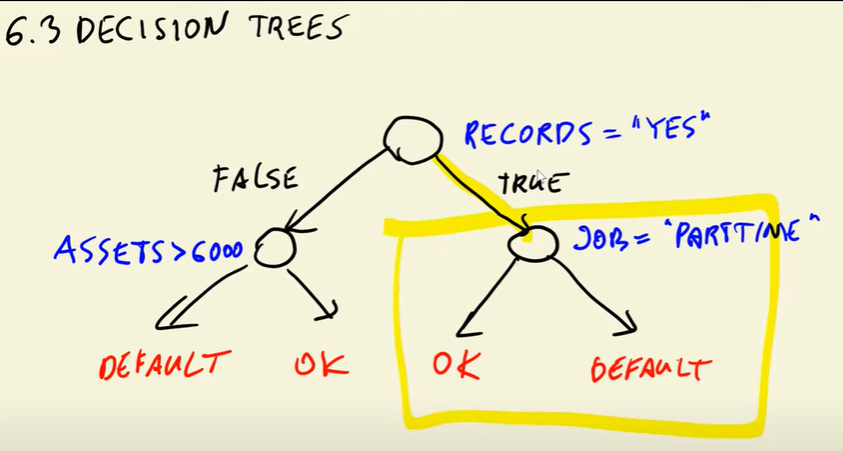

In [81]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [82]:
xi = df_train.iloc[0].to_dict()

In [83]:
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [84]:
assess_risk(xi)

'ok'

In [ ]:
from sklearn.tree import DecisionTreeClassifier    #for decision tree classifier
from sklearn.feature_extraction import DictVectorizer  #for categorical variables
from sklearn.metrics import roc_auc_score       
from sklearn.tree import export_text  #to learn what is inside the tree

In [86]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [87]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [88]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [89]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [90]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.658154924802015)

In [ ]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)  ##This is overfitting

np.float64(1.0)

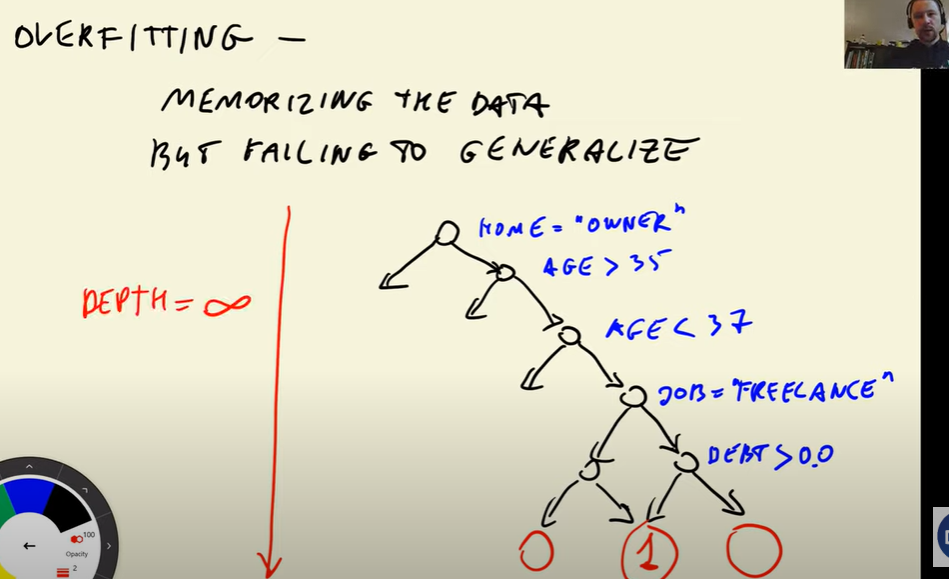

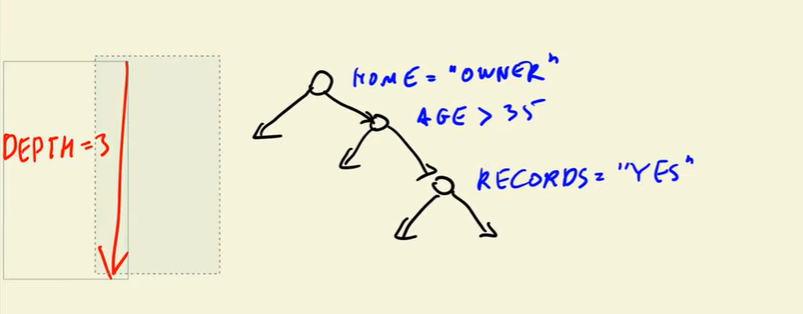

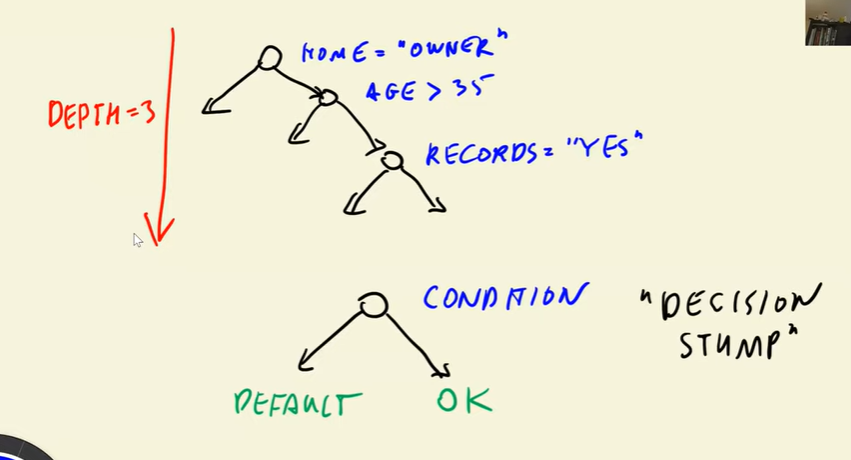

In [92]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [93]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [ ]:
#Trees conditions
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



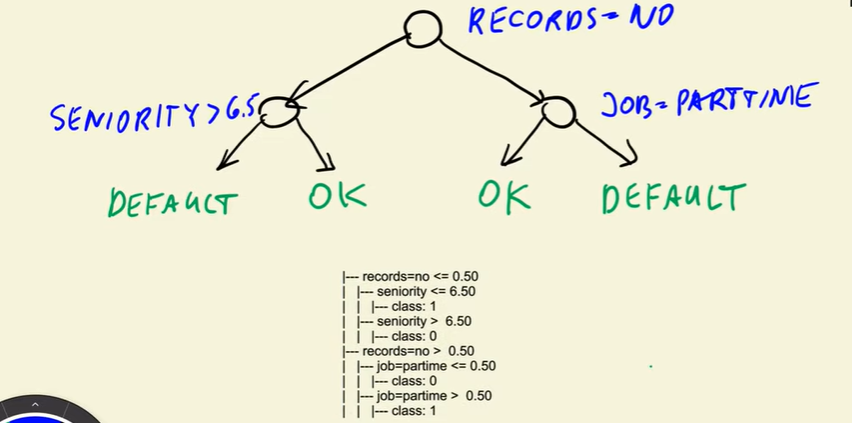

### 6.4 Decision tree learning algorithm
- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

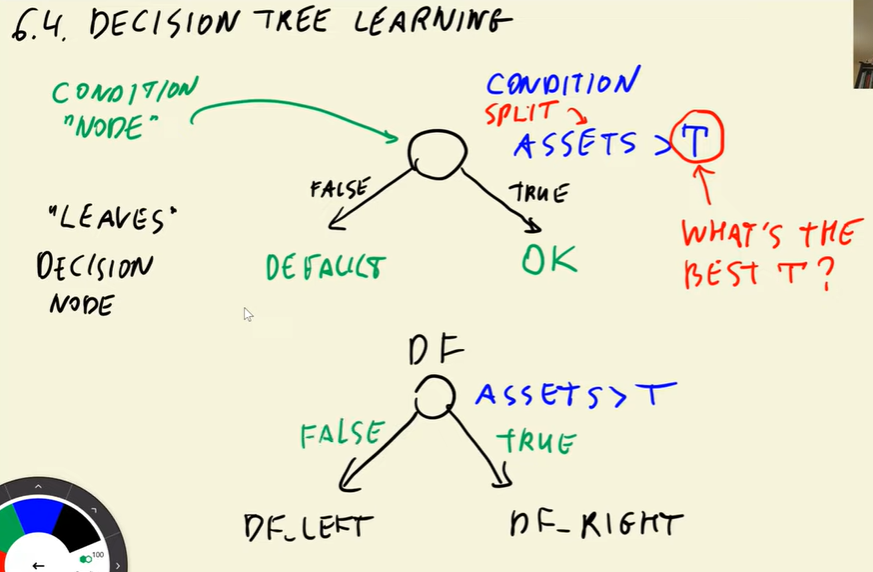

In [95]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

assets   status
0    8000  default
1    2000  default
2       0  default
3    5000       ok
4    5000       ok
5    4000       ok
6    9000       ok
7    3000  default

In [96]:
df_example.sort_values('assets')

assets   status
2       0  default
1    2000  default
7    3000  default
5    4000       ok
4    5000       ok
3    5000       ok
0    8000  default
6    9000       ok

In [97]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

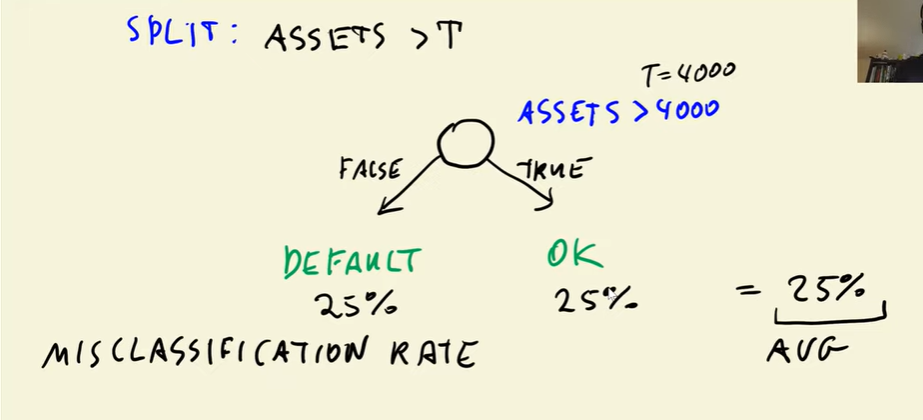

In [ ]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True)) #normalize shows ratios instead of natural numbers
display(df_right)
print(df_left.status.value_counts(normalize=True)) #miscalification rate

assets   status
1    2000  default
2       0  default
5    4000       ok
7    3000  default

status
default    0.75
ok         0.25
Name: proportion, dtype: float64


assets   status
0    8000  default
3    5000       ok
4    5000       ok
6    9000       ok

status
default    0.75
ok         0.25
Name: proportion, dtype: float64


In [98]:
from IPython.display import display

In [ ]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


assets   status
2       0  default

status
default    1.0
Name: proportion, dtype: float64


assets   status
0    8000  default
1    2000  default
3    5000       ok
4    5000       ok
5    4000       ok
6    9000       ok
7    3000  default

status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


assets   status
1    2000  default
2       0  default

status
default    1.0
Name: proportion, dtype: float64


assets   status
0    8000  default
3    5000       ok
4    5000       ok
5    4000       ok
6    9000       ok
7    3000  default

status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


assets   status
1    2000  default
2       0  default
7    3000  default

status
default    1.0
Name: proportion, dtype: float64


assets   status
0    8000  default
3    5000       ok
4    5000       ok
5    4000       ok
6    9000       ok

status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


assets   status
1    2000  default
2       0  default
5    4000       ok
7    3000  default

status
default    0.75
ok         0.25
Name: proportion, dtype: float64


assets   status
0    8000  default
3    5000       ok
4    5000       ok
6    9000       ok

status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


assets   status
1    2000  default
2       0  default
3    5000       ok
4    5000       ok
5    4000       ok
7    3000  default

status
default    0.5
ok         0.5
Name: proportion, dtype: float64


assets   status
0    8000  default
6    9000       ok

status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


assets   status
0    8000  default
1    2000  default
2       0  default
3    5000       ok
4    5000       ok
5    4000       ok
7    3000  default

status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


assets status
6    9000     ok

status
ok    1.0
Name: proportion, dtype: float64



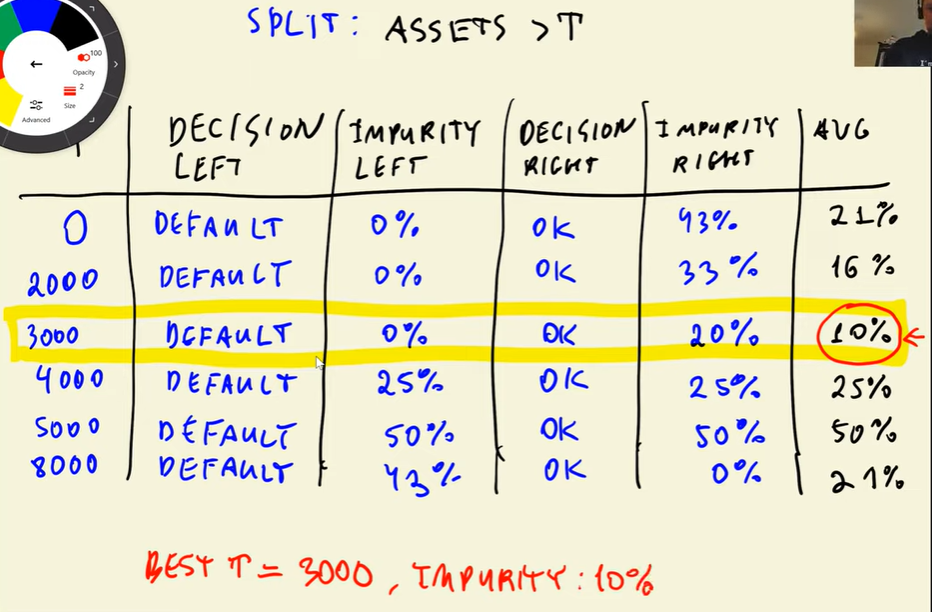



In [101]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

assets  debt   status
0    8000  3000  default
1    2000  1000  default
2       0  1000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
6    9000   500       ok
7    3000  2000  default

In [102]:
df_example.sort_values('debt')

assets  debt   status
6    9000   500       ok
1    2000  1000  default
3    5000  1000       ok
2       0  1000  default
5    4000  1000       ok
4    5000  1000       ok
7    3000  2000  default
0    8000  3000  default

In [103]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [104]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


assets  debt   status
2       0  1000  default

status
default    1.0
Name: proportion, dtype: float64


assets  debt   status
0    8000  3000  default
1    2000  1000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
6    9000   500       ok
7    3000  2000  default

status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


assets  debt   status
1    2000  1000  default
2       0  1000  default

status
default    1.0
Name: proportion, dtype: float64


assets  debt   status
0    8000  3000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
6    9000   500       ok
7    3000  2000  default

status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


assets  debt   status
1    2000  1000  default
2       0  1000  default
7    3000  2000  default

status
default    1.0
Name: proportion, dtype: float64


assets  debt   status
0    8000  3000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
6    9000   500       ok

status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


assets  debt   status
1    2000  1000  default
2       0  1000  default
5    4000  1000       ok
7    3000  2000  default

status
default    0.75
ok         0.25
Name: proportion, dtype: float64


assets  debt   status
0    8000  3000  default
3    5000  1000       ok
4    5000  1000       ok
6    9000   500       ok

status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


assets  debt   status
1    2000  1000  default
2       0  1000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
7    3000  2000  default

status
default    0.5
ok         0.5
Name: proportion, dtype: float64


assets  debt   status
0    8000  3000  default
6    9000   500       ok

status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


assets  debt   status
0    8000  3000  default
1    2000  1000  default
2       0  1000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
7    3000  2000  default

status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


assets  debt status
6    9000   500     ok

status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


assets  debt status
6    9000   500     ok

status
ok    1.0
Name: proportion, dtype: float64


assets  debt   status
0    8000  3000  default
1    2000  1000  default
2       0  1000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
7    3000  2000  default

status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


assets  debt   status
1    2000  1000  default
2       0  1000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
6    9000   500       ok

status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


assets  debt   status
0    8000  3000  default
7    3000  2000  default

status
default    1.0
Name: proportion, dtype: float64

2000


assets  debt   status
1    2000  1000  default
2       0  1000  default
3    5000  1000       ok
4    5000  1000       ok
5    4000  1000       ok
6    9000   500       ok
7    3000  2000  default

status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


assets  debt   status
0    8000  3000  default

status
default    1.0
Name: proportion, dtype: float64

#####################


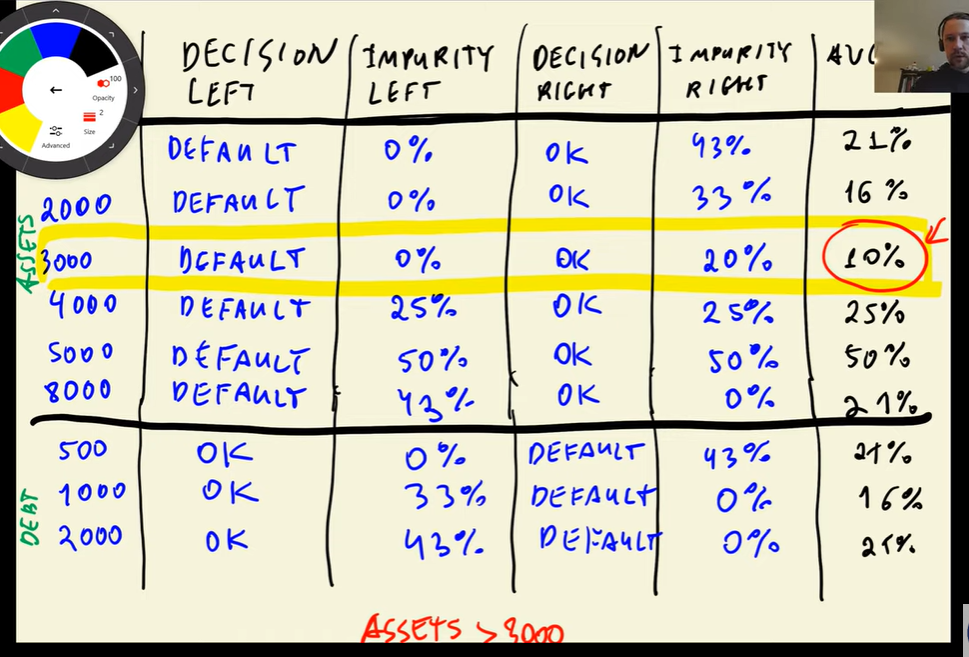

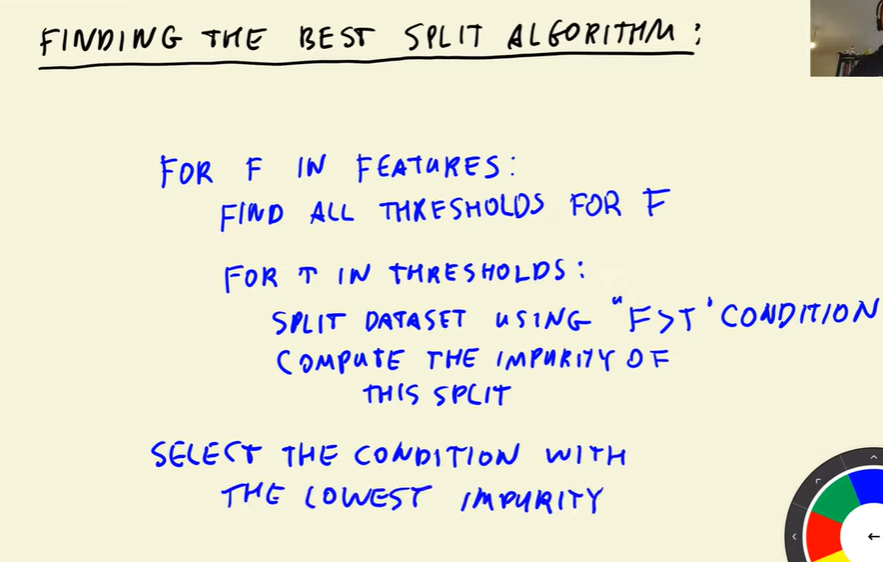

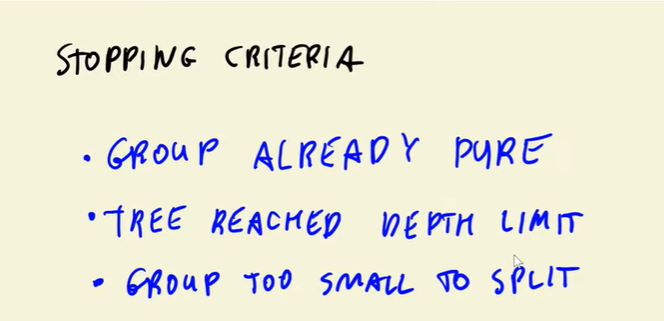

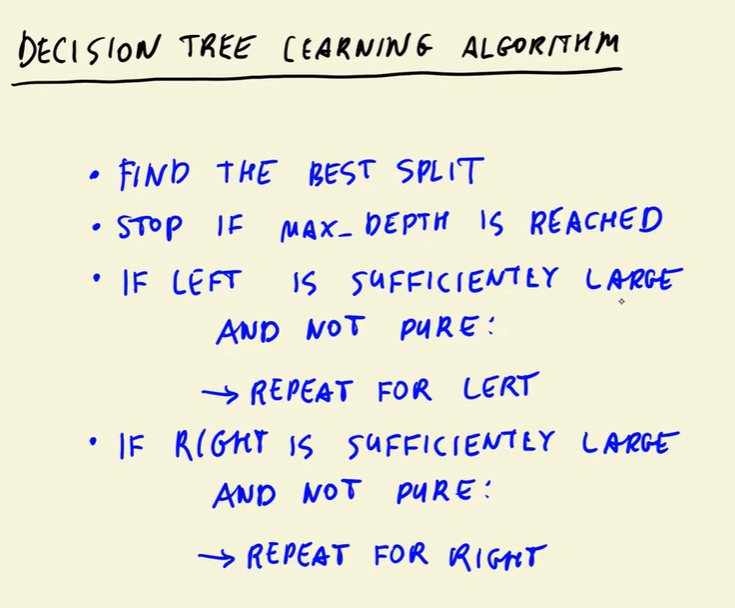

To learn more about decision trees: https://scikit-learn.org/1.5/modules/tree.html

### 6.5 Decision trees parameter tuning
- selecting max_depth
- selecting min_samples_leaf

In [108]:
"""
This script evaluates the performance of a DecisionTreeClassifier with different maximum depths
using the ROC AUC score.
The script performs the following steps:
1. Defines a list of depths to be tested.
2. Iterates over each depth value in the list.
3. For each depth:
    a. Initializes a DecisionTreeClassifier with the specified max_depth.
    b. Fits the classifier on the training data (X_train, y_train).
    c. Predicts the probabilities on the validation data (X_val).
    d. Computes the ROC AUC score using the true labels (y_val) and the predicted probabilities.
    e. Prints the depth and the corresponding ROC AUC score.
Variables:
- depths: List of integers and None, representing the maximum depths to be tested.
- dt: Instance of DecisionTreeClassifier.
- y_pred: Predicted probabilities for the positive class.
- auc: Computed ROC AUC score.
"""

depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.750
  10 -> 0.681
  15 -> 0.660
  20 -> 0.645
None -> 0.668


In [109]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [110]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [111]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.754
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

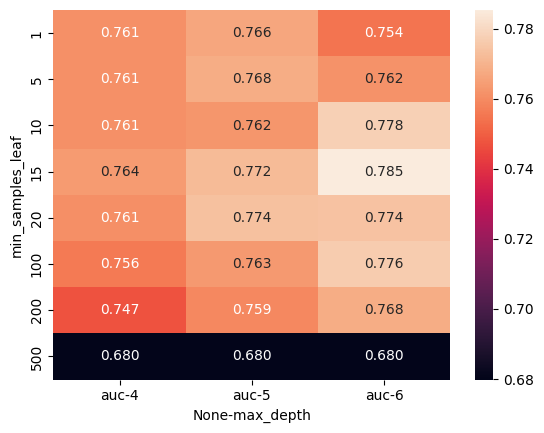

In [112]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [113]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [114]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1600.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1600.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

### 6.6 Ensembles and random forest
- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

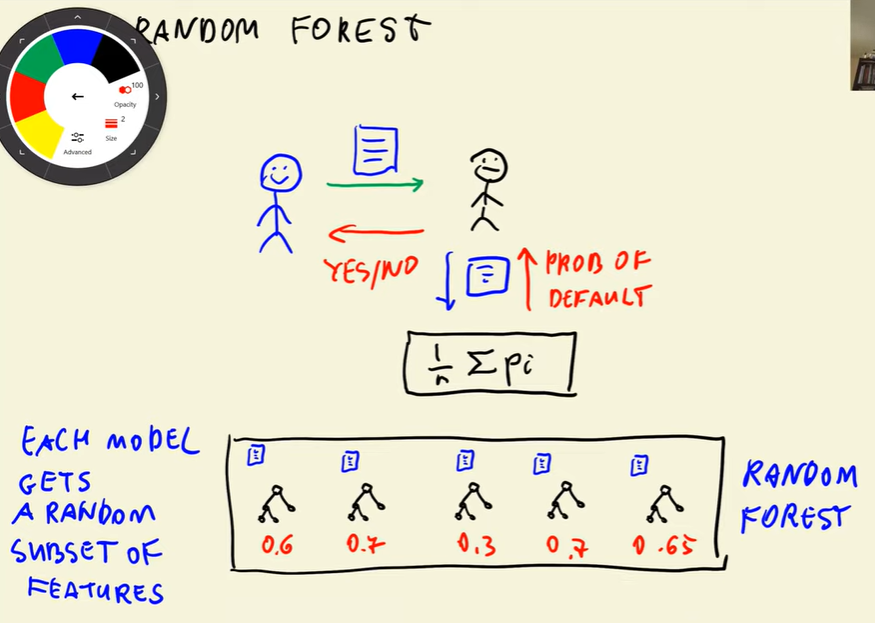

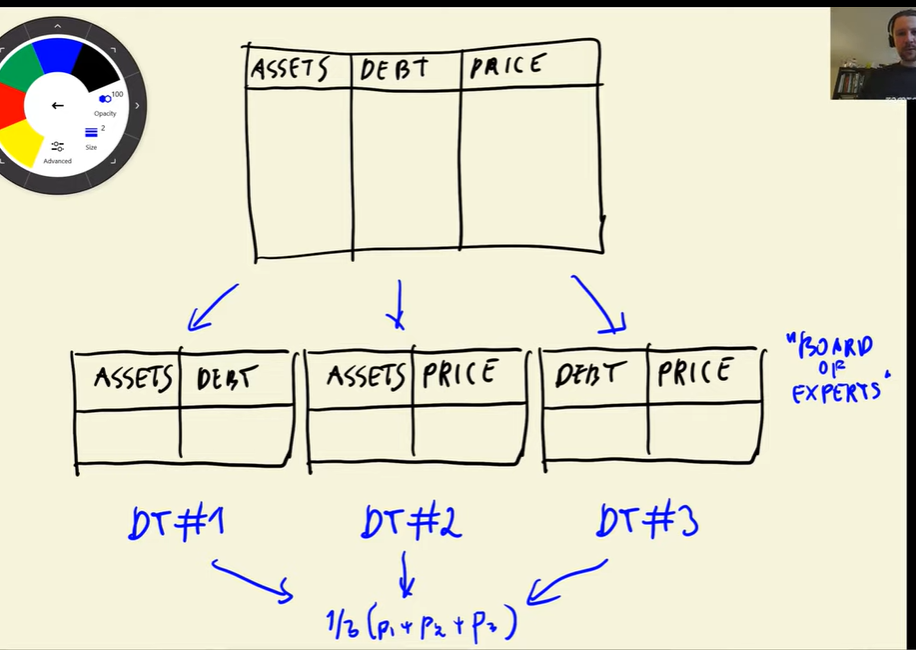

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
# for now use default parameters
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [129]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [130]:
roc_auc_score(y_val, y_pred)

np.float64(0.7744726453706618)

In [131]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

In [132]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [133]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

In [135]:
df_scores

n_estimators       auc
0             10  0.774473
1             20  0.803532
2             30  0.815075
3             40  0.815686
4             50  0.817082
5             60  0.816458
6             70  0.817321
7             80  0.816307
8             90  0.816824
9            100  0.817599
10           110  0.817527
11           120  0.817939
12           130  0.818253
13           140  0.818102
14           150  0.817270
15           160  0.817981
16           170  0.817606
17           180  0.817463
18           190  0.817981
19           200  0.819050

Text(0, 0.5, 'AUC Score')

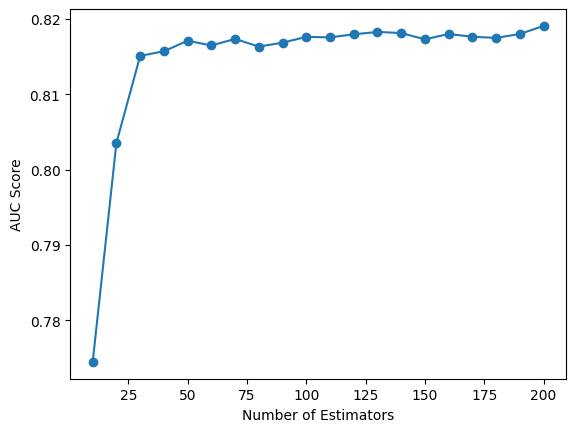

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.auc, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('AUC Score')

In [138]:
#Lets train a random forest but with different max_depths and n_estimators
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [139]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

max_depth  n_estimators       auc
0           5            10  0.787699
1           5            20  0.797731
2           5            30  0.800305
3           5            40  0.799708
4           5            50  0.799878
5           5            60  0.801167
6           5            70  0.802251
7           5            80  0.803244
8           5            90  0.803616
9           5           100  0.804452
10          5           110  0.806626
11          5           120  0.806450
12          5           130  0.808054
13          5           140  0.807019
14          5           150  0.807219
15          5           160  0.807134
16          5           170  0.806965
17          5           180  0.807261
18          5           190  0.807231
19          5           200  0.807352
20         10            10  0.791365
21         10            20  0.808496
22         10            30  0.811584
23         10            40  0.817839
24         10            50  0.817058
25         10            60  0.818656
26         10            70  0.820230
27         10            80  0.820412
28         10            90  0.819843
29         10           100  0.821169
30         10           110  0.822646
31         10           120  0.823227
32         10           130  0.824517
33         10           140  0.824129
34         10           150  0.824166
35         10           160  0.825243
36         10           170  0.824632
37         10           180  0.824801
38         10           190  0.824535
39         10           200  0.824923
40         15            10  0.794704
41         15            20  0.808848
42         15            30  0.810128
43         15            40  0.813337
44         15            50  0.813364
45         15            60  0.813101
46         15            70  0.814061
47         15            80  0.814887
48         15            90  0.815420
49         15           100  0.815983
50         15           110  0.816422
51         15           120  0.817569
52         15           130  0.817914
53         15           140  0.818308
54         15           150  0.818474
55         15           160  0.819255
56         15           170  0.819128
57         15           180  0.819855
58         15           190  0.819570
59         15           200  0.820091

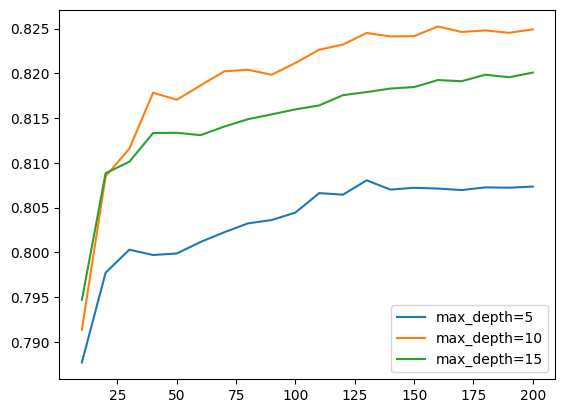

In [140]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [141]:
max_depth = 10

In [142]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [143]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [145]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]
list(zip(colors, values))

[('black', 1), ('blue', 3), ('orange', 5), ('red', 10), ('grey', 50)]

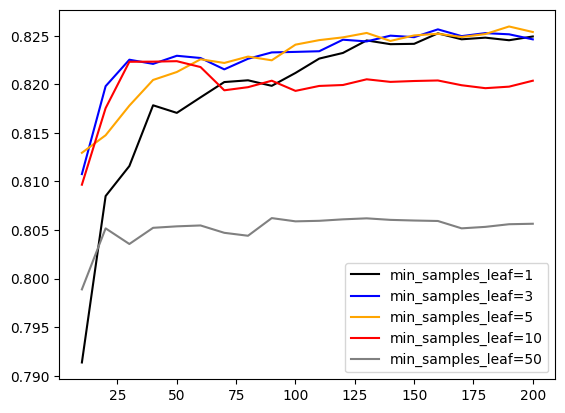

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [146]:
min_samples_leaf = 3

In [147]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Other useful parametes:

- max_features
- bootstrap

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 6.7 Gradient boosting and XGBoost
- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

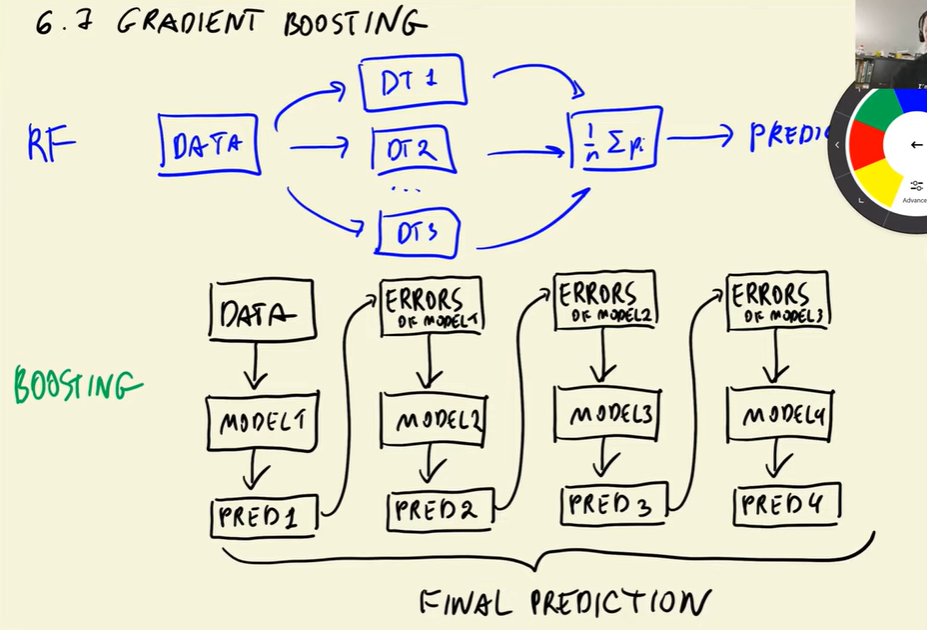

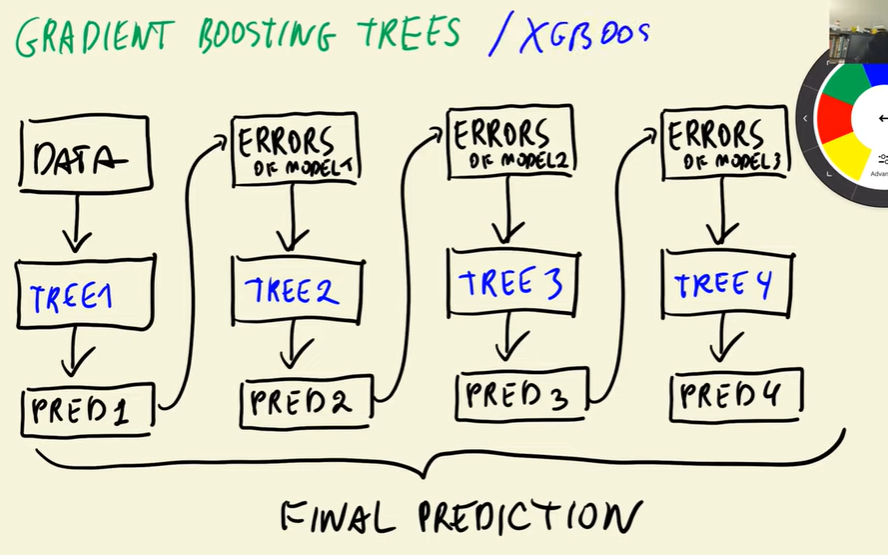

In [148]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 56.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 37.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [149]:
import xgboost as xgb

In [150]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [152]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [153]:
y_pred = model.predict(dval)

In [154]:
roc_auc_score(y_val, y_pred)

np.float64(0.8065256351262986)

In [155]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [159]:
%%capture output
"""
Trains an XGBoost model with the specified parameters.
Parameters:
xgb_params (dict): Dictionary containing the parameters for the XGBoost model.
dtrain (DMatrix): The training data in the form of an XGBoost DMatrix.
num_boost_round (int): Number of boosting rounds.
verbose_eval (int): Frequency of printing evaluation metrics.
evals (list): List of items to be evaluated during training.
Returns:
Booster: The trained XGBoost model.
Note:
The output of the training process is captured and stored in the 'output' variable.
"""

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,  #print eval every five steps
                  evals=watchlist)

In [157]:
s = output.stdout

In [158]:
print(s[:200])

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	tr


In [161]:
line = s.split('\n')[0]
line

'[0]\ttrain-auc:0.86730\tval-auc:0.77938'

In [162]:
num_iter, train_auc, val_auc = line.split('\t')

In [163]:
int(num_iter.strip('[]')
    )

0

In [164]:
float(train_auc.split(':')[1])

0.8673

In [165]:
float(val_auc.split(':')[1])

0.77938

In [166]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [167]:
df_score = parse_xgb_output(output)

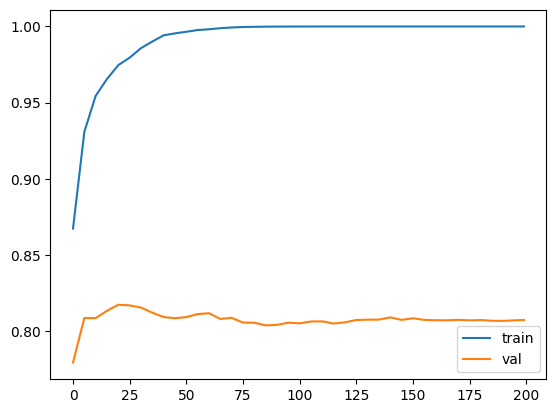

In [168]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

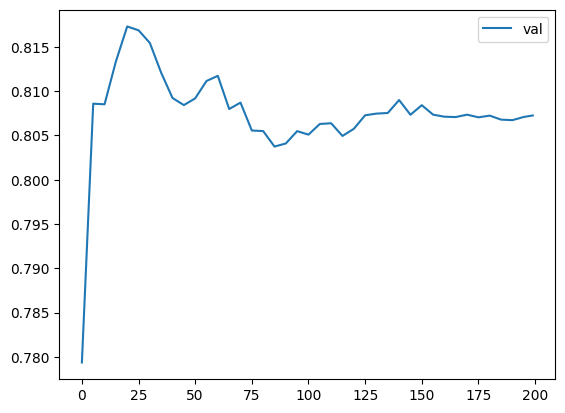

In [169]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

### 6.8 XGBoost parameter tuning
Tuning the following parameters:

- eta
- max_depth
- min_child_weight

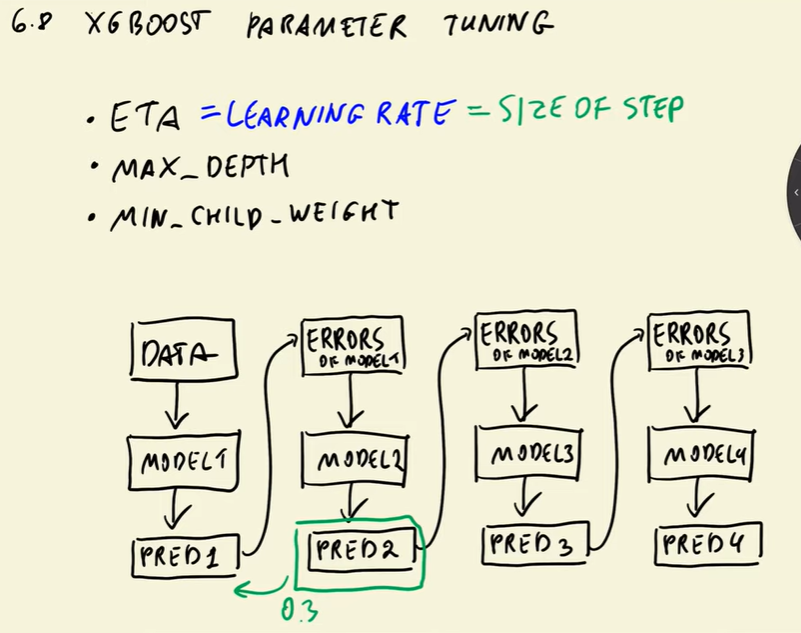

In [187]:
scores = {}

In [202]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [203]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [204]:
scores.keys()

dict_keys(['eta=1.0', 'eta=0.3', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

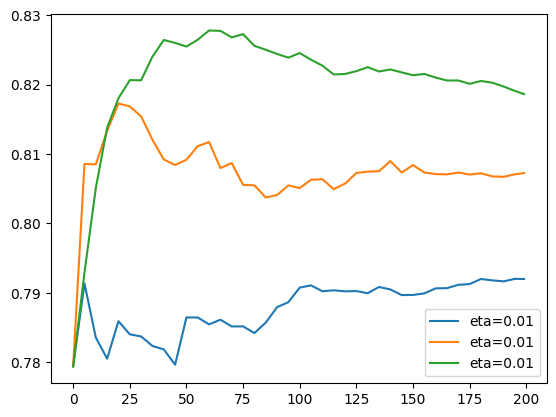

In [206]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

First fine tune ETA, then max_depth, lastly min_child_weight (min_sample_leafs)

In [210]:
scores = {}

In [217]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [218]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [219]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10'])

In [221]:
del scores['max_depth=10'] 

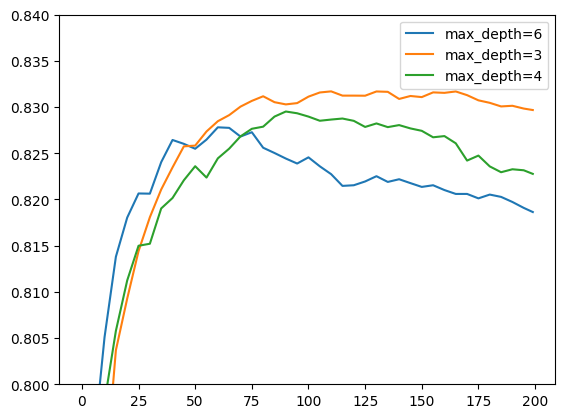

In [222]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84) #to zoom in
plt.legend()

In [231]:
scores = {}

In [236]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [237]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [238]:
scores.keys()

dict_keys(['min_child_weight=30', 'min_child_weight=10', 'min_child_weight=1'])

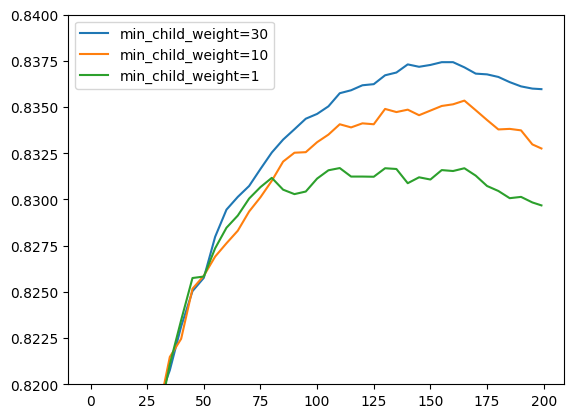

In [240]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

In [241]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175) #taking 175 as the best number of iterations from the graph 

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Finetunig: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

Useful ones:

- subsample and colsample_bytree
- lambda and alpha

### 6.9 Selecting the final model
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [242]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [243]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7854738320699426)

In [ ]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [245]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.8246258264512848)

In [246]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [247]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.8309347073212081)

In [252]:
y_full_train = (df_full_train.status == 'default').astype(int).values

AttributeError: 'DataFrame' object has no attribute 'status'

In [ ]:
del df_full_train['status']

In [ ]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False) #convert matrix to vector
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [257]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [258]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [259]:
y_pred = model.predict(dtest)

In [260]:
roc_auc_score(y_test, y_pred)

np.float64(0.8289367577342261)

### 6.10 Summary
- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.

### 6.11 Explore more
- For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
- For random forest, there are more parameters that we can tune. Check max_features and bootstrap.
- There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in ExtraTreesClassifier. Try it for this project.
- XGBoost can deal with NAs - we don't have to do fillna for it. Check if not filling NA's help improve performance.
- Experiment with other XGBoost parameters: subsample and colsample_bytree.
- When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for random forest (it's the same for plain decision trees) and for xgboost
- Trees can also be used for solving the regression problems: check DecisionTreeRegressor, RandomForestRegressor and the objective=reg:squarederror parameter for XGBoost.